In [1]:
from Controller import *

import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
def preprocess_and_show(img, state):
    hsv_image = preprocess(img, state)
    img = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
def show(img):
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
def show_lines_on_image(img, lines, state):
    hsv_image = preprocess(img, state)
    temp_img = cv2.cvtColor(hsv_image.copy(), cv2.COLOR_HSV2RGB)
    for line in lines:
        if line is not None:
            x1, y1, x2, y2 = line[0]
            cv2.line(temp_img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    show(temp_img)

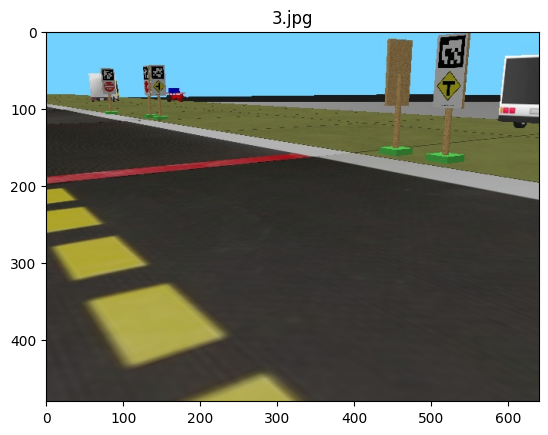

In [3]:
path = "observations_test"
title = "3.jpg"
state = State.INITIALIZING
img = cv2.cvtColor(cv2.imread(os.path.join(path, title)), cv2.COLOR_BGR2RGB)
show(img)

Mode.INITIAL
[[ 30  60 130 150]] [[293   2 637  68]] [[  8  47 341  12]]


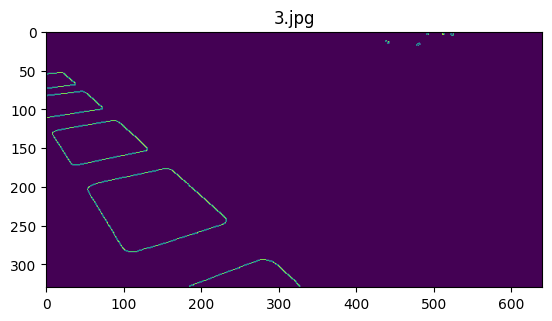

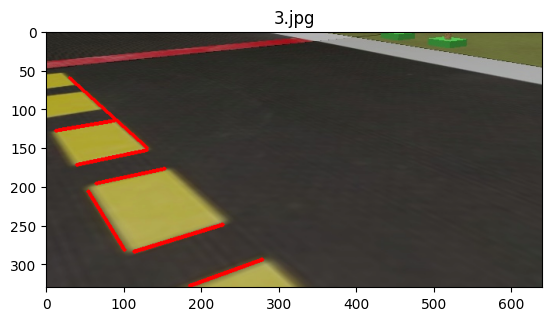

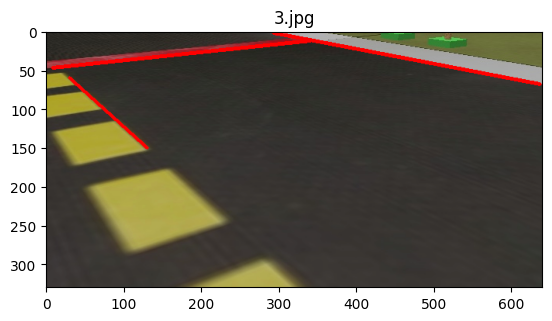

In [4]:
mode = get_mode_from_state(state)
print(mode)
yellow, white, red = get_lane_lines(img, state)
print(yellow, white, red)

edges = get_edges(preprocess(img, state), color="yellow", blur=True)
lines = get_lines_in_image(edges)

show(edges)
show_lines_on_image(img, lines, state) 

show_lines_on_image(img, [yellow, white, red], state)

In [ ]:
d_est = get_d_est(yellow, white, mode)
heading = get_heading(yellow, white)

if (red is not None) and state in (State.IN_LANE_USING_RED, State.IN_LANE_AND_WAITING_TO_TURN, State.IN_LANE_AND_FORWARD):
    heading = get_heading_from_red_line(red) 
    
if state == State.TURNING_WITHIN_LANE:
    heading = np.radians(np.degrees(np.arctan(slope(white))) - 28)
    
if state == State.CROSSING_INTERSECTION:
    if (yellow is None) and (white is not None):  # left only intersection
        heading = np.radians(np.degrees(np.arctan(slope(white))) - 28)
    else:  # no lines visible, go straight
        heading = 0
        d_est = 0

k_p, k_d = get_pid_params_for(state)
steering = k_p * d_est + k_d * heading
speed = get_speed(steering, state)

print(k_p, k_d)
print("d_est = ", d_est)
print("heading = ", heading, ", and in degrees = ", np.degrees(heading))
print("steering = ", steering)
print("speed = ", speed)

In [ ]:
if yellow is not None: 
    print("yellow_slope:", angle_in_degrees(yellow) )
    print("yellow_distance:", get_distance_from_line(yellow, mode))
if white is not None: 
    print("white_slope:", angle_in_degrees(white))
    print("white_distance:", get_distance_from_line(white, mode))
if red is not None:
    print("red_slope:", angle_in_degrees(red))
    print("red_distance:", get_distance_from_line(red, mode))
    

# print(np.degrees(np.arctan(slope(red))))
# print(np.degrees(np.arctan((-1/slope(red)))))
#(get_distance_from_line(yellow, mode) - get_distance_from_line(white, mode))/2
#np.degrees(np.arctan(slope(yellow))) - 90 + DEGREES_OFFSET
#get_distance_from_line(yellow, mode) - one_side_distance_offset(mode)

In [ ]:
#for line in lines:
for line in filter_outlier_lines(lines):
    print(line, np.around(np.degrees(np.arctan(slope(line)))), get_distance_from_line(line, mode), get_length(line))
    show_lines_on_image(img, [line], state) 

In [ ]:
slopes = [abs(np.around(np.degrees(np.arctan(slope(line))))) for line in lines]
mean = np.mean(slopes)
std = np.std(slopes)
print(mean, std)
print(min(2 * std, 15))

In [ ]:
filtered_lines = [line for line in lines if (abs(mean - abs(np.around(np.degrees(np.arctan(slope(line)))))) <= min(2 * std, 15))]